# Bayesian vs. Frequentist Fair Coin Hypothesis Testing

We answer whether a coin is fair or not based on a coin-flip experiment using Bayesian and Frequentist hypothesis testing methodologies.

In [26]:
%matplotlib notebook

from __future__ import division

from scipy import stats
import scipy.special as sps
import numpy as np
import matplotlib.pyplot as plt

# Follows https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb
def coin_flipper(N, pi=0.5, seed=42):
    """Returns a coin flip, where 1 is heads and 0 is tails.

    Parameters
    ----------
    N : int
        Number of flips in the experiment.
    pi : float in [0, 1], optional.
        The probability of the coin returning heads.  Default: 0.5.
    seed : None or int or `np.random.RandomState` instance, optional
        Seed value.  Default: 42.
    """
    return stats.bernoulli.rvs(pi, size=N, random_state=seed)

## Bayesian Methodology

Following [these lecture notes](http://idiom.ucsd.edu/~rlevy/lign251/fall2007/lecture_9.pdf) from [Roger Levy's Linguistics 251 course](http://idiom.ucsd.edu/~rlevy/lign251/fall2007/), let us set up two hypotheses, $H_f$ that the coin is fair, and $H_{uf}$ that it is unfair.  Assume our data is $\vec{x}$.  Then

\begin{eqnarray}
P(H_f|\vec{x}) &=& \frac{P(\vec{x}|H_f)P(H_f)}{P(\vec{x})} \\
P(H_{uf}|\vec{x}) &=& 1 - P(H_f|\vec{x})
\end{eqnarray}

Moreover, we must marginalize over the possible hypotheses:

$$
P(\vec{x}) = P(\vec{x}|H_f)P(H_f) + P(\vec{x}|H_{uf})P(H_{uf})
$$

To use these equations, we'll need to specify the hypotheses and their probabilities.  Take $\pi$ to be probability of heads (more generally the Bernoulli parameter).  Then, for $H_f$, we have $P(\pi|H_f) = 1$ if $\pi = 0.5$ and $P(\pi|H_f) = 0$ if $\pi \neq 0.5$. Then:

$$
P(\vec{x}|H_f) = \sum_i P(\vec{x}|\pi_i)P(\pi_i|H_f) = P(\vec{x}|\pi_i = 0.5) = {n\choose n_\mathrm{heads}}\frac{1}{2^n}
$$

Where we have used the fact that $P(\vec{x}|\pi_i) =  {n\choose n_\mathrm{heads}} \pi^{n_\mathrm{heads}}(1 - \pi)^{n_\mathrm{tails}}$.

For $H_{uf}$ we run into a problem, since we'd likely want to assume $\pi \in [0, 1]$ (and is thus uniformly distributed), and is equally likely to take on any value within that range.  In that case:

$$
P(\vec{x}|H_{uf}) = \sum_i P(\vec{x}|\pi_i)P(\pi_i|H_{uf}) = \int_0^1 P(\vec{x}|\pi_i)P(\pi_i)d\pi
$$

$P(\pi_i) = 1$ for a uniform RV about $[0, 1]$, and $P(\vec{x}|\pi_i)$ is the same as from above.  As it turns out, the following relation holds:

$$
\int_0^1 \pi^{a}(1 - \pi)^{b}d\pi = \frac{\Gamma(a + 1)\Gamma(b + 1)}{\Gamma(a + b + 2)} = \frac{a!b!}{(a + b + 1)!}
$$

Where $\Gamma$ is the usual [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).  This simplifies cancels with the ${n\choose n_\mathrm{heads}}$ and thus,

$$
P(\vec{x}|H_{uf}) = \frac{1}{n_\mathrm{heads} + n_\mathrm{tails} + 1}
$$

Assuming we have no prior information, $P(H_f) = P(H_{uf}) = 0.5$.  In cases like this where both hypotheses have equally likely priors, we can use the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor), the ratio of likelihoods between two hypotheses, to determine which to favour.  (In cases where there are multiple hypotheses with equal priors, we would take the maximum among them, which would have the highest Bayes factor when compared against any other hypothesis.)

In [2]:
def get_prob_xhf(heads, tails):
    return sps.comb(heads + tails, heads) / 2.**(heads + tails)

def get_prob_xhuf(heads, tails):
    return float(heads + tails + 1)**(-1)

def get_cointoss_bayesian(experiment):
    """Determine whether the coin is fair using Bayesian hypothesis testing.
    
    Parameters
    ----------
    experiment : list-like
        Output from `coin_flipper`.
    
    Returns
    -------
    prob_hf : float
        Probability the coin is fair.
    bayes_factor : float
        Bayes factor P(H_f) / P(H_uf).    
    """
    heads = np.sum(experiment)
    tails = len(experiment) - heads
    prob_xhf = get_prob_xhf(heads, tails)
    prob_xhuf = get_prob_xhuf(heads, tails)
    prob_hf = prob_xhf / (prob_xhf + prob_xhuf)
    return prob_hf, prob_xhf / prob_xhuf

def print_cointoss_bayesian(experiment, name):
    print("Experiment {0} - heads/all: {1:d}/{2:d} = {3:.2f},"
          " P(H_f): {4:.4f}, Bayes Factor: {5:.4f}"
          .format(name, np.sum(experiment), len(experiment),
                  np.sum(experiment)/len(experiment), 
                  *get_cointoss_bayesian(experiment)))

In [3]:
experiment_f1 = coin_flipper(30, pi=0.5, seed=42)
print_cointoss_bayesian(experiment_f1, "F1")

Experiment F1 - heads/all: 13/30 = 0.43, P(H_f): 0.7757, Bayes Factor: 3.4576


In [4]:
experiment_f2 = coin_flipper(387, pi=0.5, seed=584)
print_cointoss_bayesian(experiment_f2, "F2")

Experiment F2 - heads/all: 183/387 = 0.47, P(H_f): 0.8991, Bayes Factor: 8.9065


In [5]:
experiment_f3 = coin_flipper(1000, pi=0.5, seed=465156)
print_cointoss_bayesian(experiment_f3, "F3")

Experiment F3 - heads/all: 502/1000 = 0.50, P(H_f): 0.9616, Bayes Factor: 25.0492


In [6]:
experiment_uf1 = coin_flipper(27, pi=0.34, seed=56)
print_cointoss_bayesian(experiment_uf1, "UF1")

Experiment UF1 - heads/all: 10/27 = 0.37, P(H_f): 0.6377, Bayes Factor: 1.7599


In [7]:
experiment_uf2 = coin_flipper(91, pi=0.34, seed=51564)
print_cointoss_bayesian(experiment_uf2, "UF2")

Experiment UF2 - heads/all: 32/91 = 0.35, P(H_f): 0.1210, Bayes Factor: 0.1377


In [8]:
experiment_uf3 = coin_flipper(72, pi=0.55, seed=7651)
print_cointoss_bayesian(experiment_uf3, "UF3")

Experiment UF3 - heads/all: 40/72 = 0.56, P(H_f): 0.8151, Bayes Factor: 4.4090


In [9]:
experiment_uf4 = coin_flipper(787, pi=0.55, seed=4555)
print_cointoss_bayesian(experiment_uf4, "UF4")

Experiment UF4 - heads/all: 431/787 = 0.55, P(H_f): 0.3857, Bayes Factor: 0.6280


Since we use a naive prior, the probabilities can readily be transformed back and forth from the Bayes Factors.

For fair coins, the Bayes Factor increases to double-digits as the number of flips reaches around 500.  For a very unfair coin ($\pi = 0.34$) we that even for around 100 flips the Bayes Factor drops below 0.1.  For a slightly unfair coin, however ($\pi = 0.55$), the possibility of the coin being fair cannot easily be ruled out, even when close to 1000 flips.

Past 1000 flips, we run into the trouble of calculating very large numbers, so we switch to Stirling's approximation for $\ln  {N\choose n}$ , from [Wikipedia](https://en.wikipedia.org/wiki/Stirling%27s_approximation).

In [10]:
def stirling_lnfac(n):
    return n * (np.log(n) - 1.) + 0.5 * np.log(2. * np.pi * n)

def stirling_lnncr(n, r):
    return ((n - r + 0.5) * np.log(n / (n - r)) +
            r * np.log(n / r) - 0.5 * np.log(2. * np.pi * r))

def get_ln_prob_xhf(heads, tails):
    # Use Stirling's approximation
    return stirling_lnncr(heads + tails, heads) - (heads + tails) * np.log(2.)

def get_ln_prob_xhuf(heads, tails):
    return -np.log(float(heads + tails + 1))

def get_cointoss_logbayesfactor(experiment):
    """Determine whether the coin is fair using Bayesian hypothesis testing.
    
    Approximates the natural log probability of H_f with Stirling's formula.
    
    Parameters
    ----------
    experiment : list-like
        Output from `coin_flipper`.
    
    Returns
    -------
    prob_hf : float
        Probability the coin is fair.
    bayes_factor : float
        Bayes factor P(H_f) / P(H_uf).    
    """
    heads = np.sum(experiment)
    tails = len(experiment) - heads
    ln_prob_xhf = get_ln_prob_xhf(heads, tails)
    ln_prob_xhuf = get_ln_prob_xhuf(heads, tails)
    ln_bayes_factor = ln_prob_xhf - ln_prob_xhuf
    bayes_factor = np.exp(ln_bayes_factor)
    prob_hf = 1. / (1. + 1. / bayes_factor)
    return prob_hf, bayes_factor

def print_cointoss_logbayes(experiment, name):
    print("Experiment {0} - heads/all: {1:d}/{2:d} = {3:.2f},"
          " P(H_f): {4:.4f}, Bayes Factor: {5:.4f}"
          .format(name, np.sum(experiment), len(experiment),
                  np.sum(experiment)/len(experiment), 
                  *get_cointoss_logbayesfactor(experiment)))

In [11]:
experiment_uf5 = coin_flipper(1787, pi=0.55, seed=4555)
print_cointoss_logbayes(experiment_uf4, "UF5")

Experiment UF5 - heads/all: 431/787 = 0.55, P(H_f): 0.3858, Bayes Factor: 0.6282


In [12]:
experiment_uf6 = coin_flipper(2565, pi=0.55, seed=4894)
print_cointoss_logbayes(experiment_uf6, "UF6")

Experiment UF6 - heads/all: 1393/2565 = 0.54, P(H_f): 0.0029, Bayes Factor: 0.0029


In [13]:
experiment_uf6 = coin_flipper(3780, pi=0.55, seed=47923)
print_cointoss_logbayes(experiment_uf6, "UF6")

Experiment UF6 - heads/all: 2167/3780 = 0.57, P(H_f): 0.0000, Bayes Factor: 0.0000


It takes several thousand samples before we can conculsively favour the unfair hypothesis over the fair one.

## Frequentist Methodology

Following [these lecture notes](http://idiom.ucsd.edu/~rlevy/lign251/fall2007/lecture_7.pdf) from Levy's course, let's first recall that the sum of square errors of $n$ independent standard normal RVs is **chi-square distributed**.  More generally, for $n$ IID normal RVs,

\begin{eqnarray}
\frac{1}{\sigma^2}\sum_{i=1}^n(x_i - \hat{\mu})^2 &\sim& \chi^2_{n-1} \\
\hat{\mu} &=& \frac{1}{n}\sum_{i=1}^n x_i
\end{eqnarray}

where subscript $n - 1$ indicates $n - 1$ degrees of freedom.  (Proof by [Cochran's Theorem](https://en.wikipedia.org/wiki/Cochran%27s_theorem).)

<IPython.core.display.Javascript object>


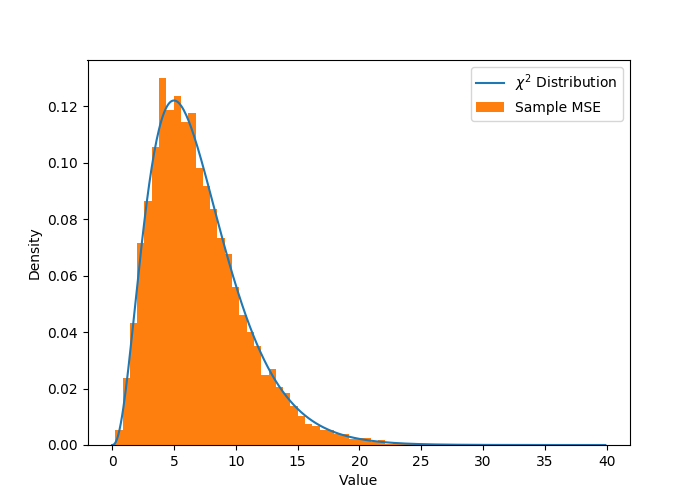

In [66]:
mu = 5.6861
sigma = 3.68

sample_sums = np.empty(10000)
for i in range(sample_sums.shape[0]):
    samples = np.random.normal(loc=mu, scale=sigma, size=7)
    sample_sums[i] = (samples - mu).dot(samples - mu) / sigma**2

x = np.arange(0., 40., 0.1)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, stats.chi2.pdf(x, 7), label=r'$\chi^2$ Distribution')
ax.hist(sample_sums, bins=50, density=True, label='Sample MSE')
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.legend(loc=1);

We define the **$t$ distribution** as the ratio of a standard normal RV and a $\chi^2$ one, i.e.

$$
t_n = \frac{Z}{\sqrt{U / n}}
$$

where $Z \sim \mathcal{N}(0, 1)$, $U \sim \chi^2_n$ and $n$ is the number of degrees of freedom.  When $n >> 1$, $t_n \rightarrow Z$.

The Confidence and Credible Interval notebook has a proof of why the $t$ distribution is used in hypothesis testing of IID normal RV samples.

https://www.annualreviews.org/doi/full/10.1146/annurev-statistics-031017-100307